In [53]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.transforms import (
    LoadImaged, EnsureChannelFirstd, ResizeD, ScaleIntensityd, ToTensord,
    LoadImage, EnsureChannelFirst, Resize, ScaleIntensity, ToTensor, Compose
)
from monai.data import Dataset, DataLoader
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.bundle import ConfigParser


In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [46]:
# Paths
cohort_path = "../data/PI-CAI/cohort.csv"
file_data_root = "../data/PI-CAI/file_data"
model_weights = "../models/prostate_mri_anatomy/models/model.pt"
config_path = "../models/prostate_mri_anatomy/configs/inference.json"
bundle_dir = "../models/prostate_mri_anatomy"


In [47]:
# Load cohort CSV
df = pd.read_csv(cohort_path)

In [48]:
# Build list of data dictionaries
data_dicts = [
    {
        "image": os.path.join(file_data_root, row["T2W_NIFTI"]),
        "label": os.path.join(file_data_root, row["Gland_NIFTI"])
    }
    for _, row in df.iterrows()
]

In [49]:
# Preprocessing pipeline (same as used during evaluation)
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ResizeD(keys=["image", "label"], spatial_size=(96, 96, 96)),
    ScaleIntensityd(keys="image"),
    ToTensord(keys=["image", "label"])
])

In [50]:
# Create Dataset and DataLoader
train_ds = Dataset(data=data_dicts, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)

In [51]:
# Load model from MONAI bundle config
parser = ConfigParser()
parser.read_config(config_path)
parser["bundle_root"] = bundle_dir

# Load model architecture
network = parser.get_parsed_content("network_def").to(device)

# Load pretrained weights
weights = torch.load(os.path.join(bundle_dir, "models/model.pt"), map_location=device)
network.load_state_dict(weights)
network.train()  # set to training mode


UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.15, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.15, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit2): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, t

In [52]:
# Dice + CrossEntropy loss for multi-class segmentation
loss_fn = DiceCELoss(to_onehot_y=False, softmax=True)

# Optimizer
optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)


### Model Fine-Tuning Loop

This cell performs fine-tuning of the pre-trained segmentation model on the D2 dataset for a fixed number of epochs. The steps involved are:

- The model is set to training mode at the beginning of each epoch.
- For each batch of training data, T2-weighted images and corresponding gland labels are loaded and transferred to the computation device (CPU or GPU).
- The model performs a forward pass to predict the segmentation output.
- The Dice + Cross Entropy loss is computed using only the central gland channel from the predictions.
- The loss is backpropagated, and the optimizer updates the model parameters.
- The average loss for the epoch is logged to monitor training progress.


In [25]:
from tqdm import tqdm

num_epochs = 5

for epoch in range(num_epochs):
    network.train()
    epoch_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
        t2, gland = batch
        t2, gland = batch["image"].to(device), batch["label"].to(device)


        # Forward pass
        outputs = network(t2)
        loss = loss_fn(outputs[:, 1:2], gland)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss:.4f}")


Epoch 1:   0%|          | 0/80 [00:00<?, ?it/s]/Users/venkateshtalasila/My Files/GitHub Repositories/prostate-gland-segmentation-on-MRI/prostate-seg-env/lib/python3.10/site-packages/monai/losses/dice.py:147: UserWarning: single channel prediction, `softmax=True` ignored.
  warnings.warn("single channel prediction, `softmax=True` ignored.")
Epoch 1: 100%|██████████| 80/80 [02:20<00:00,  1.75s/it]


Epoch 1/5, Average Loss: 1.2870


Epoch 2: 100%|██████████| 80/80 [02:17<00:00,  1.72s/it]


Epoch 2/5, Average Loss: 1.1440


Epoch 3: 100%|██████████| 80/80 [02:23<00:00,  1.79s/it]


Epoch 3/5, Average Loss: -1.6007


Epoch 4: 100%|██████████| 80/80 [02:19<00:00,  1.75s/it]


Epoch 4/5, Average Loss: 2.4603


Epoch 5: 100%|██████████| 80/80 [02:23<00:00,  1.79s/it]

Epoch 5/5, Average Loss: 1.6516


In [30]:
# Manual preprocessing pipeline for a single image
preprocess = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    Resize((96, 96, 96)),
    ScaleIntensity(),
    ToTensor()
])

# Preprocessing helper
def preprocess_image(path):
    return preprocess(path).unsqueeze(0)  # [1, C, D, H, W]

In [ ]:
print("\n🔍 Evaluating fine-tuned model on D2...")
df = pd.read_csv(cohort_path)
dice_metric = DiceMetric(include_background=False, reduction="mean")
dice_scores = []

network.eval()  # Make sure we're in eval mode

for idx, row in tqdm(df.iterrows(), total=len(df)):
    patient_id = row["patientID"]
    print(f"\n🧪 Processing patient: {patient_id}")

    try:
        t2_path = os.path.join(file_data_root, row["T2W_NIFTI"])
        gland_path = os.path.join(file_data_root, row["Gland_NIFTI"])

        t2_tensor = preprocess_image(t2_path).to(device)
        gland_tensor = preprocess_image(gland_path).to(device)

        with torch.no_grad():
            pred = sliding_window_inference(
                inputs=t2_tensor,
                roi_size=(96, 96, 96),
                sw_batch_size=1,
                predictor=network
            )
            pred_bin = (pred[:, 1:2] > 0.5).float()  # channel 1 = central gland
            gland_tensor[gland_tensor > 0] = 1.0     # binarize GT

        print(f"Pred sum: {pred_bin.sum().item():.2f}, GT sum: {gland_tensor.sum().item():.2f}")
        dice_metric.reset()
        dice_metric(y_pred=pred_bin, y=gland_tensor)
        score = dice_metric.aggregate().item()

        dice_scores.append((patient_id, score))
        print(f"✅ Dice Score: {score:.4f}")

    except Exception as e:
        print(f"❌ Error processing patient {patient_id}: {e}")



🔍 Evaluating fine-tuned model on D2...


  0%|          | 0/80 [00:00<?, ?it/s]


🧪 Processing patient: 11284


  1%|▏         | 1/80 [00:00<01:11,  1.11it/s]

Pred sum: 209927.00, GT sum: 884730.00
✅ Dice Score: 0.3835

🧪 Processing patient: 10372


  2%|▎         | 2/80 [00:01<01:01,  1.27it/s]

Pred sum: 155893.00, GT sum: 884733.00
✅ Dice Score: 0.2996

🧪 Processing patient: 10768


  4%|▍         | 3/80 [00:02<00:55,  1.38it/s]

Pred sum: 262182.00, GT sum: 884733.00
✅ Dice Score: 0.4572

🧪 Processing patient: 10074


  5%|▌         | 4/80 [00:02<00:53,  1.43it/s]

Pred sum: 257500.00, GT sum: 884733.00
✅ Dice Score: 0.4509

🧪 Processing patient: 10418


  6%|▋         | 5/80 [00:03<00:51,  1.45it/s]

Pred sum: 197674.00, GT sum: 884730.00
✅ Dice Score: 0.3652

🧪 Processing patient: 11165


  8%|▊         | 6/80 [00:04<00:50,  1.47it/s]

Pred sum: 240535.00, GT sum: 884730.00
✅ Dice Score: 0.4275

🧪 Processing patient: 10442


  9%|▉         | 7/80 [00:04<00:49,  1.49it/s]

Pred sum: 258027.00, GT sum: 884733.00
✅ Dice Score: 0.4516

🧪 Processing patient: 10486


 10%|█         | 8/80 [00:05<00:48,  1.49it/s]

Pred sum: 171157.00, GT sum: 884733.00
✅ Dice Score: 0.3242

🧪 Processing patient: 10043


 11%|█▏        | 9/80 [00:06<00:47,  1.50it/s]

Pred sum: 224104.00, GT sum: 884730.00
✅ Dice Score: 0.4042

🧪 Processing patient: 10164


 12%|█▎        | 10/80 [00:06<00:47,  1.47it/s]

Pred sum: 252906.00, GT sum: 884733.00
✅ Dice Score: 0.4446

🧪 Processing patient: 10241


 14%|█▍        | 11/80 [00:07<00:46,  1.48it/s]

Pred sum: 238883.00, GT sum: 884730.00
✅ Dice Score: 0.4252

🧪 Processing patient: 10522


 15%|█▌        | 12/80 [00:08<00:45,  1.50it/s]

Pred sum: 282887.00, GT sum: 884733.00
✅ Dice Score: 0.4845

🧪 Processing patient: 10728


 16%|█▋        | 13/80 [00:08<00:44,  1.52it/s]

Pred sum: 201946.00, GT sum: 884733.00
✅ Dice Score: 0.3717

🧪 Processing patient: 10825


 18%|█▊        | 14/80 [00:09<00:43,  1.51it/s]

Pred sum: 253793.00, GT sum: 884733.00
✅ Dice Score: 0.4458

🧪 Processing patient: 11137


 19%|█▉        | 15/80 [00:10<00:43,  1.49it/s]

Pred sum: 258214.00, GT sum: 884733.00
✅ Dice Score: 0.4518

🧪 Processing patient: 11236


 20%|██        | 16/80 [00:10<00:42,  1.52it/s]

Pred sum: 284904.00, GT sum: 884733.00
✅ Dice Score: 0.4872

🧪 Processing patient: 11361


 21%|██▏       | 17/80 [00:11<00:41,  1.53it/s]

Pred sum: 200963.00, GT sum: 884733.00
✅ Dice Score: 0.3702

🧪 Processing patient: 10107


 22%|██▎       | 18/80 [00:12<00:41,  1.49it/s]

Pred sum: 246760.00, GT sum: 884730.00
✅ Dice Score: 0.4362

🧪 Processing patient: 10539


 24%|██▍       | 19/80 [00:12<00:41,  1.47it/s]

Pred sum: 217870.00, GT sum: 884733.00
✅ Dice Score: 0.3952

🧪 Processing patient: 10743


 25%|██▌       | 20/80 [00:13<00:41,  1.46it/s]

Pred sum: 294852.00, GT sum: 884733.00
✅ Dice Score: 0.4999

🧪 Processing patient: 10910


 26%|██▋       | 21/80 [00:14<00:39,  1.48it/s]

Pred sum: 301873.00, GT sum: 884733.00
✅ Dice Score: 0.5088

🧪 Processing patient: 11051


 28%|██▊       | 22/80 [00:14<00:38,  1.49it/s]

Pred sum: 238759.00, GT sum: 884730.00
✅ Dice Score: 0.4250

🧪 Processing patient: 11086


 29%|██▉       | 23/80 [00:15<00:38,  1.49it/s]

Pred sum: 237031.00, GT sum: 884733.00
✅ Dice Score: 0.4226

🧪 Processing patient: 11155


 30%|███       | 24/80 [00:16<00:37,  1.48it/s]

Pred sum: 249656.00, GT sum: 884730.00
✅ Dice Score: 0.4402

🧪 Processing patient: 11444


 31%|███▏      | 25/80 [00:17<00:37,  1.47it/s]

Pred sum: 225983.00, GT sum: 884730.00
✅ Dice Score: 0.4069

🧪 Processing patient: 10005


 32%|███▎      | 26/80 [00:17<00:36,  1.47it/s]

Pred sum: 180306.00, GT sum: 884730.00
✅ Dice Score: 0.3386

🧪 Processing patient: 10329


 34%|███▍      | 27/80 [00:18<00:35,  1.49it/s]

Pred sum: 240869.00, GT sum: 884733.00
✅ Dice Score: 0.4280

🧪 Processing patient: 10434


 35%|███▌      | 28/80 [00:18<00:34,  1.50it/s]

Pred sum: 223724.00, GT sum: 884730.00
✅ Dice Score: 0.4037

🧪 Processing patient: 10484


 36%|███▋      | 29/80 [00:19<00:34,  1.47it/s]

Pred sum: 263882.00, GT sum: 884733.00
✅ Dice Score: 0.4595

🧪 Processing patient: 10807


 38%|███▊      | 30/80 [00:20<00:33,  1.48it/s]

Pred sum: 216875.00, GT sum: 884733.00
✅ Dice Score: 0.3937

🧪 Processing patient: 10888


 39%|███▉      | 31/80 [00:21<00:33,  1.44it/s]

Pred sum: 269231.00, GT sum: 884733.00
✅ Dice Score: 0.4666

🧪 Processing patient: 11177


 40%|████      | 32/80 [00:21<00:34,  1.39it/s]

Pred sum: 275297.00, GT sum: 884733.00
✅ Dice Score: 0.4746

🧪 Processing patient: 11253


 41%|████▏     | 33/80 [00:22<00:36,  1.30it/s]

Pred sum: 251542.00, GT sum: 884730.00
✅ Dice Score: 0.4427

🧪 Processing patient: 11300


 42%|████▎     | 34/80 [00:23<00:34,  1.33it/s]

Pred sum: 219352.00, GT sum: 884730.00
✅ Dice Score: 0.3973

🧪 Processing patient: 10085


 44%|████▍     | 35/80 [00:24<00:32,  1.36it/s]

Pred sum: 213502.00, GT sum: 884733.00
✅ Dice Score: 0.3888

🧪 Processing patient: 10274


 45%|████▌     | 36/80 [00:24<00:31,  1.38it/s]

Pred sum: 221245.00, GT sum: 884733.00
✅ Dice Score: 0.4001

🧪 Processing patient: 10380


 46%|████▋     | 37/80 [00:25<00:30,  1.40it/s]

Pred sum: 237691.00, GT sum: 884730.00
✅ Dice Score: 0.4235

🧪 Processing patient: 10390


 48%|████▊     | 38/80 [00:26<00:31,  1.33it/s]

Pred sum: 312739.00, GT sum: 884733.00
✅ Dice Score: 0.5223

🧪 Processing patient: 10665


 49%|████▉     | 39/80 [00:27<00:30,  1.35it/s]

Pred sum: 207261.00, GT sum: 884733.00
✅ Dice Score: 0.3796

🧪 Processing patient: 10872


 50%|█████     | 40/80 [00:27<00:29,  1.37it/s]

Pred sum: 263047.00, GT sum: 884733.00
✅ Dice Score: 0.4584

🧪 Processing patient: 11168


 51%|█████▏    | 41/80 [00:28<00:28,  1.38it/s]

Pred sum: 228521.00, GT sum: 884730.00
✅ Dice Score: 0.4105

🧪 Processing patient: 10059


 52%|█████▎    | 42/80 [00:29<00:27,  1.38it/s]

Pred sum: 213424.00, GT sum: 884730.00
✅ Dice Score: 0.3887

🧪 Processing patient: 10262


 54%|█████▍    | 43/80 [00:30<00:28,  1.31it/s]

Pred sum: 194562.00, GT sum: 884730.00
✅ Dice Score: 0.3605

🧪 Processing patient: 10322


 55%|█████▌    | 44/80 [00:30<00:27,  1.31it/s]

Pred sum: 208450.00, GT sum: 884730.00
✅ Dice Score: 0.3814

🧪 Processing patient: 10340


 56%|█████▋    | 45/80 [00:31<00:26,  1.34it/s]

Pred sum: 245604.00, GT sum: 884733.00
✅ Dice Score: 0.4346

🧪 Processing patient: 10607


 57%|█████▊    | 46/80 [00:32<00:24,  1.36it/s]

Pred sum: 210742.00, GT sum: 884730.00
✅ Dice Score: 0.3848

🧪 Processing patient: 10798


 59%|█████▉    | 47/80 [00:33<00:24,  1.33it/s]

Pred sum: 257733.00, GT sum: 884733.00
✅ Dice Score: 0.4512

🧪 Processing patient: 10839


 60%|██████    | 48/80 [00:33<00:23,  1.35it/s]

Pred sum: 194548.00, GT sum: 884730.00
✅ Dice Score: 0.3605

🧪 Processing patient: 10915


 61%|██████▏   | 49/80 [00:34<00:23,  1.33it/s]

Pred sum: 312771.00, GT sum: 884733.00
✅ Dice Score: 0.5224

🧪 Processing patient: 11231


 62%|██████▎   | 50/80 [00:35<00:21,  1.37it/s]

Pred sum: 232409.00, GT sum: 884730.00
✅ Dice Score: 0.4161

🧪 Processing patient: 11278


 64%|██████▍   | 51/80 [00:35<00:21,  1.37it/s]

Pred sum: 223252.00, GT sum: 884730.00
✅ Dice Score: 0.4030

🧪 Processing patient: 10040


 65%|██████▌   | 52/80 [00:36<00:20,  1.36it/s]

Pred sum: 222383.00, GT sum: 884730.00
✅ Dice Score: 0.4017

🧪 Processing patient: 10117


 66%|██████▋   | 53/80 [00:37<00:20,  1.32it/s]

Pred sum: 254177.00, GT sum: 884733.00
✅ Dice Score: 0.4464

🧪 Processing patient: 10168


 68%|██████▊   | 54/80 [00:38<00:19,  1.36it/s]

Pred sum: 314203.00, GT sum: 884730.00
✅ Dice Score: 0.5241

🧪 Processing patient: 10211


 69%|██████▉   | 55/80 [00:38<00:17,  1.41it/s]

Pred sum: 213689.00, GT sum: 884730.00
✅ Dice Score: 0.3891

🧪 Processing patient: 10216


 70%|███████   | 56/80 [00:39<00:16,  1.42it/s]

Pred sum: 211390.00, GT sum: 884733.00
✅ Dice Score: 0.3857

🧪 Processing patient: 10339


 71%|███████▏  | 57/80 [00:40<00:15,  1.45it/s]

Pred sum: 220455.00, GT sum: 884733.00
✅ Dice Score: 0.3989

🧪 Processing patient: 10568


 72%|███████▎  | 58/80 [00:40<00:15,  1.43it/s]

Pred sum: 192871.00, GT sum: 884730.00
✅ Dice Score: 0.3580

🧪 Processing patient: 10668


 74%|███████▍  | 59/80 [00:41<00:14,  1.46it/s]

Pred sum: 289816.00, GT sum: 884733.00
✅ Dice Score: 0.4935

🧪 Processing patient: 10699


 75%|███████▌  | 60/80 [00:42<00:13,  1.47it/s]

Pred sum: 236346.00, GT sum: 884730.00
✅ Dice Score: 0.4216

🧪 Processing patient: 11122


 76%|███████▋  | 61/80 [00:42<00:12,  1.48it/s]

Pred sum: 193409.00, GT sum: 884730.00
✅ Dice Score: 0.3588

🧪 Processing patient: 11188


 78%|███████▊  | 62/80 [00:43<00:11,  1.50it/s]

Pred sum: 284260.00, GT sum: 884733.00
✅ Dice Score: 0.4863

🧪 Processing patient: 11247


 79%|███████▉  | 63/80 [00:44<00:11,  1.50it/s]

Pred sum: 241401.00, GT sum: 884730.00
✅ Dice Score: 0.4287

🧪 Processing patient: 11260


 80%|████████  | 64/80 [00:44<00:10,  1.52it/s]

Pred sum: 274433.00, GT sum: 884733.00
✅ Dice Score: 0.4735

🧪 Processing patient: 11280


 81%|████████▏ | 65/80 [00:45<00:09,  1.53it/s]

Pred sum: 216474.00, GT sum: 884733.00
✅ Dice Score: 0.3932

🧪 Processing patient: 10048


 82%|████████▎ | 66/80 [00:46<00:09,  1.53it/s]

Pred sum: 277965.00, GT sum: 884730.00
✅ Dice Score: 0.4781

🧪 Processing patient: 10097


 84%|████████▍ | 67/80 [00:46<00:08,  1.49it/s]

Pred sum: 253327.00, GT sum: 884733.00
✅ Dice Score: 0.4452

🧪 Processing patient: 10233


 85%|████████▌ | 68/80 [00:47<00:07,  1.52it/s]

Pred sum: 196814.00, GT sum: 884733.00
✅ Dice Score: 0.3639

🧪 Processing patient: 10268


 86%|████████▋ | 69/80 [00:48<00:07,  1.52it/s]

Pred sum: 209643.00, GT sum: 884733.00
✅ Dice Score: 0.3831

🧪 Processing patient: 10294


 88%|████████▊ | 70/80 [00:48<00:06,  1.53it/s]

Pred sum: 175735.00, GT sum: 884733.00
✅ Dice Score: 0.3314

🧪 Processing patient: 10503


 89%|████████▉ | 71/80 [00:49<00:05,  1.52it/s]

Pred sum: 214860.00, GT sum: 884730.00
✅ Dice Score: 0.3908

🧪 Processing patient: 10589


 90%|█████████ | 72/80 [00:50<00:05,  1.53it/s]

Pred sum: 216654.00, GT sum: 884730.00
✅ Dice Score: 0.3934

🧪 Processing patient: 10804


 91%|█████████▏| 73/80 [00:50<00:04,  1.52it/s]

Pred sum: 211009.00, GT sum: 884730.00
✅ Dice Score: 0.3851

🧪 Processing patient: 10968


 92%|█████████▎| 74/80 [00:51<00:03,  1.52it/s]

Pred sum: 169759.00, GT sum: 884733.00
✅ Dice Score: 0.3220

🧪 Processing patient: 11229


 94%|█████████▍| 75/80 [00:52<00:03,  1.53it/s]

Pred sum: 203753.00, GT sum: 884730.00
✅ Dice Score: 0.3744

🧪 Processing patient: 11384


 95%|█████████▌| 76/80 [00:52<00:02,  1.49it/s]

Pred sum: 240185.00, GT sum: 884733.00
✅ Dice Score: 0.4270

🧪 Processing patient: 10157


 96%|█████████▋| 77/80 [00:53<00:01,  1.50it/s]

Pred sum: 171172.00, GT sum: 884730.00
✅ Dice Score: 0.3242

🧪 Processing patient: 10383


 98%|█████████▊| 78/80 [00:54<00:01,  1.51it/s]

Pred sum: 183316.00, GT sum: 884730.00
✅ Dice Score: 0.3433

🧪 Processing patient: 11256


 99%|█████████▉| 79/80 [00:54<00:00,  1.50it/s]

Pred sum: 193208.00, GT sum: 884730.00
✅ Dice Score: 0.3585

🧪 Processing patient: 11448


100%|██████████| 80/80 [00:55<00:00,  1.44it/s]

Pred sum: 204905.00, GT sum: 884730.00
✅ Dice Score: 0.3761


### Training Loss Analysis

The average training loss across 5 epochs is as follows:

- **Epoch 1:** 1.2870
- **Epoch 2:** 1.1440
- **Epoch 3:** -1.6007 (unexpected negative loss)
- **Epoch 4:** 2.4603 (significant spike)
- **Epoch 5:** 1.6516

The loss values show instability, especially in epochs 3 and 4. A negative loss value and a sudden spike suggest potential issues such as:
- Numerical instability during loss computation or backpropagation
- Inappropriate scaling or normalization of inputs/labels
- Problems with the dataset or labels (e.g., mismatched shapes or class imbalance)

This behavior indicates that the fine-tuning process might not be converging as expected, and adjustments to preprocessing, learning rate, or loss formulation may be necessary.


In [32]:
# Save results to dataframe
results_df = pd.DataFrame(dice_scores, columns=["patientID", "dice"])
results_df.to_csv("results_finetuned.csv", index=False)
print("\n📊 Average Dice Score on D2:", results_df["dice"].mean())


📊 Average Dice Score on D2: 0.414088948443532


In [33]:
print("\n📊 DICE SCORE ANALYSIS")
print(results_df["dice"].describe())  # mean, std, min, 25%, 50%, 75%, max


📊 DICE SCORE ANALYSIS
count    80.000000
mean      0.414089
std       0.050411
min       0.299614
25%       0.382687
50%       0.405558
75%       0.447481
max       0.524128
Name: dice, dtype: float64


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns  # als

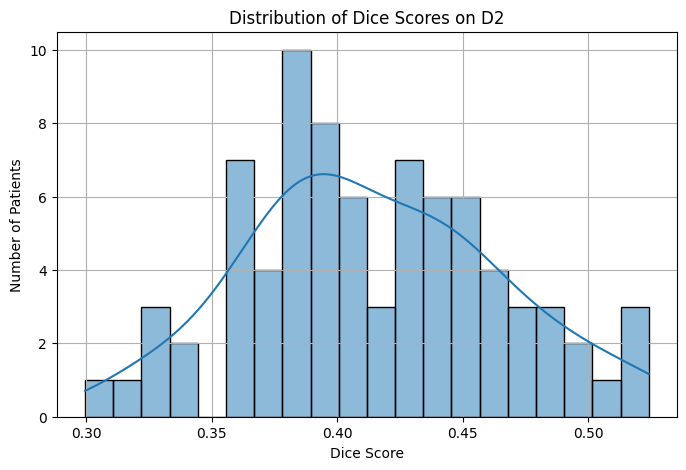

In [38]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["dice"].dropna(), bins=20, kde=True)
plt.title("Distribution of Dice Scores on D2")
plt.xlabel("Dice Score")
plt.ylabel("Number of Patients")
plt.grid(True)
plt.show()

In [39]:
print("\n🔍 Worst performing patients:")
print(results_df.sort_values("dice").head(5))


🔍 Worst performing patients:
    patientID      dice
1       10372  0.299614
73      10968  0.321973
7       10486  0.324195
76      10157  0.324219
69      10294  0.331425


In [40]:
print("\n✅ Best performing patients:")
print(results_df.sort_values("dice", ascending=False).head(5))


✅ Best performing patients:
    patientID      dice
53      10168  0.524128
48      10915  0.522368
37      10390  0.522327
20      10910  0.508801
19      10743  0.499925


In [41]:
def visualize_prediction(patient_id):
    import matplotlib.pyplot as plt
    import numpy as np
    import os

    t2_path = os.path.join(file_data_root, f"{patient_id}/{patient_id}_t2w.nii.gz")
    gland_path = os.path.join(file_data_root, f"{patient_id}/{patient_id}_gland.nii.gz")

    t2_tensor = preprocess_image(t2_path).to(device)
    gland_tensor = preprocess_image(gland_path).to(device)

    # Binarize GT
    #gland_tensor[gland_tensor > 0] = 1.0

    with torch.no_grad():
        pred = sliding_window_inference(
            inputs=t2_tensor,
            roi_size=(96, 96, 96),
            sw_batch_size=1,
            predictor=network
        )

        # Channel 1 = Central Gland
        pred_bin = (pred[:, 1:2] > 0.5).float()

    # Convert to numpy and squeeze
    t2_np = t2_tensor.cpu().squeeze().numpy()        # [D, H, W]
    gland_np = gland_tensor.cpu().squeeze().numpy()  # [D, H, W]
    pred_np = pred_bin.cpu().squeeze().numpy()       # [D, H, W]

    # Binary GT for cleaner visual
    #gland_np = np.clip(gland_np, 0, 1)

    slice_idx = t2_np.shape[2] // 2  # Z-slice for axial view

    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(t2_np[:, :, slice_idx], cmap="gray")
    plt.title("T2 Image")

    plt.subplot(1, 3, 2)
    plt.imshow(gland_np[:, :, slice_idx], cmap="Reds", vmin=0, vmax=1)
    plt.title(f"Patient {patient_id}\nGround Truth Gland")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_np[:, :, slice_idx], cmap="Blues", vmin=0, vmax=1)
    plt.title("Predicted Gland")

    plt.tight_layout()
    plt.show()


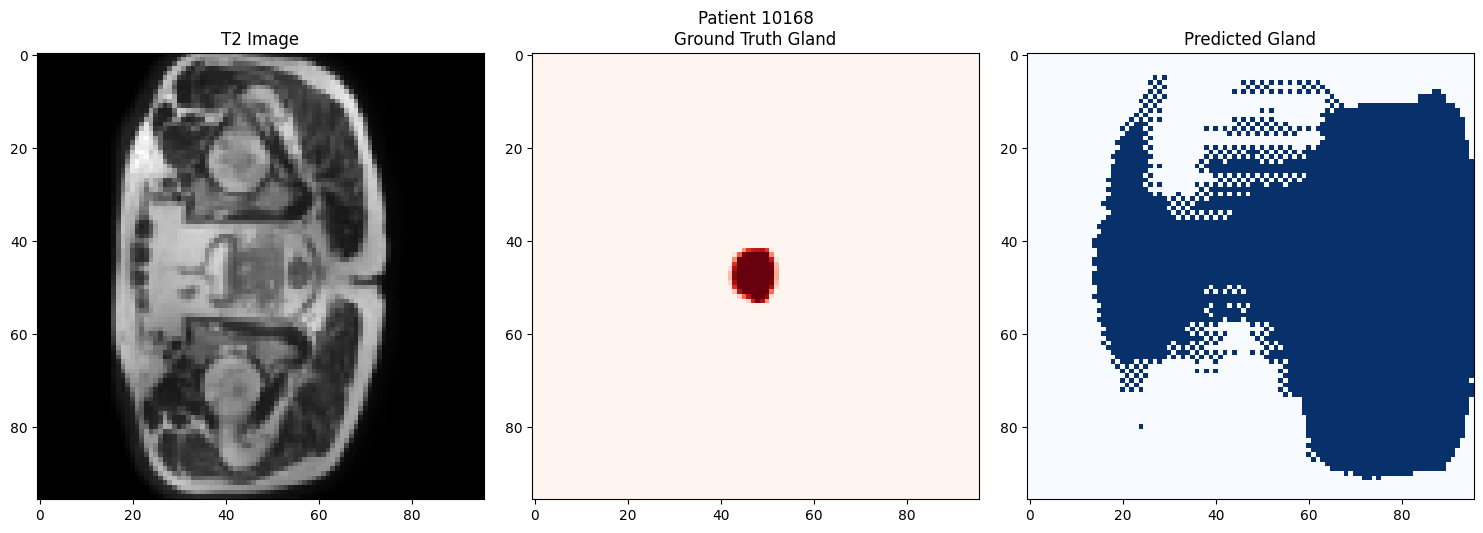

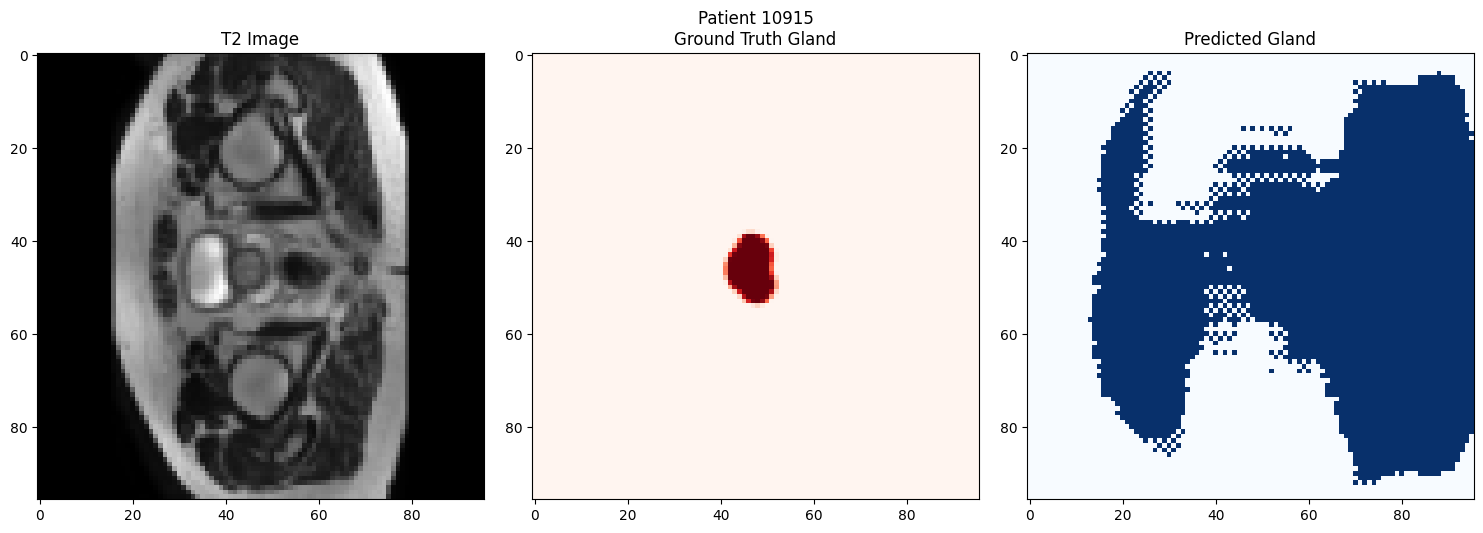

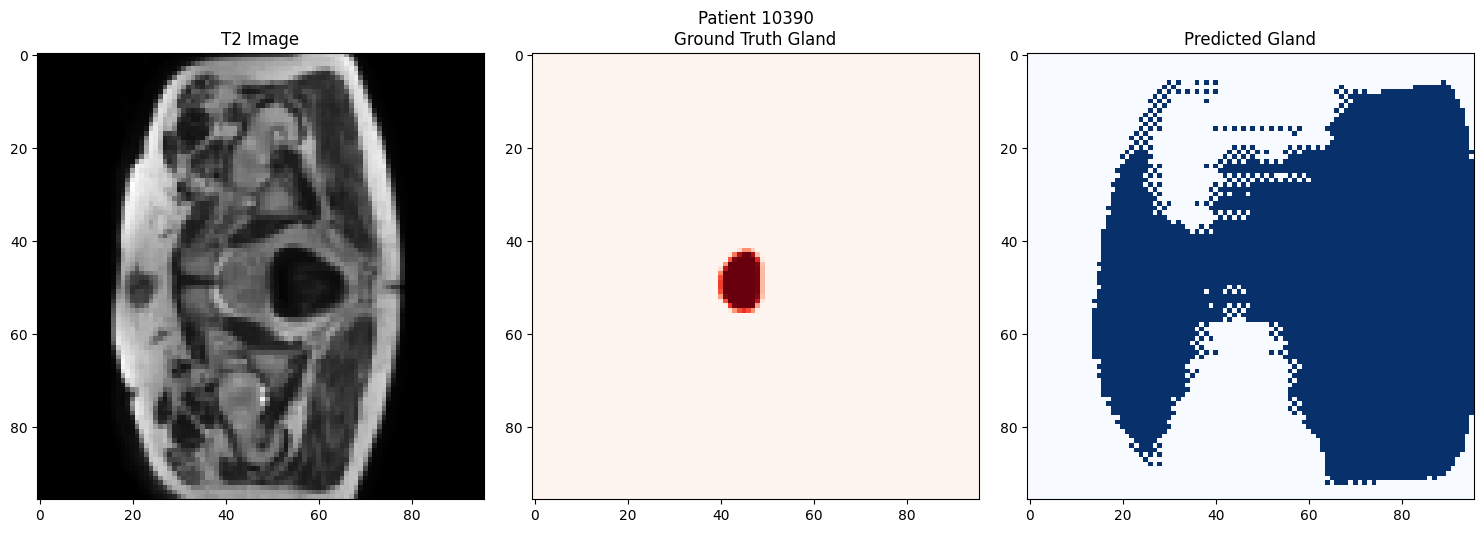

In [42]:
for pid in results_df.sort_values("dice", ascending=False).head(3)["patientID"]:
    visualize_prediction(pid)  # Best 3

### Analysis of Best 3 Performing Patients

- **Visual Overlap with Ground Truth**: In the best-performing cases, the predicted gland masks show better spatial alignment with the ground truth regions compared to the worst-performing examples. The predictions generally cover the correct anatomical zone, although they still exhibit noticeable over-segmentation.

- **Prediction Pattern**: The model tends to over-predict the gland area, especially in the anterior and lateral prostate regions. This could indicate a tendency to misclassify surrounding tissue or difficulty in separating central gland (CG) and peripheral zone (PZ) due to channel confusion.

- **T2 Image Quality**: These examples have relatively clear and well-defined gland structures in the T2-weighted images. Better contrast and fewer imaging artifacts may be contributing to improved model performance on these patients.

- **Remaining Challenges**: Despite being among the top predictions, these cases still show excessive predicted regions and lack precise boundaries. The model captures the location but not the shape or extent accurately, highlighting the need for better fine-tuning or post-processing on the D2 dataset.


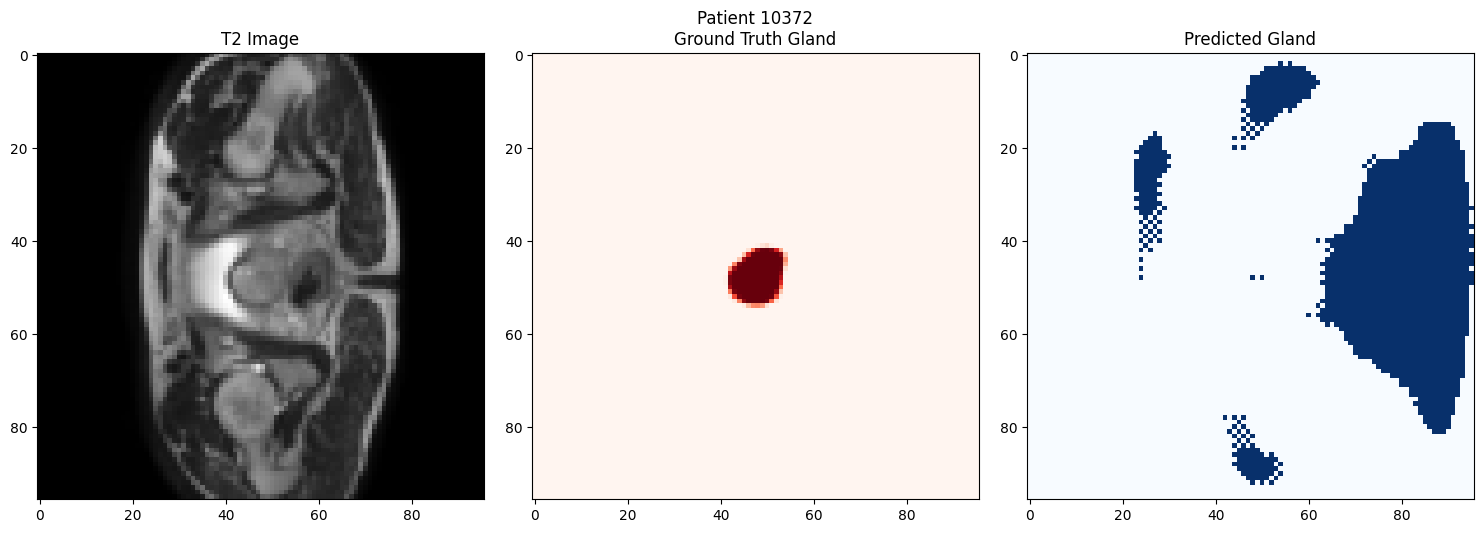

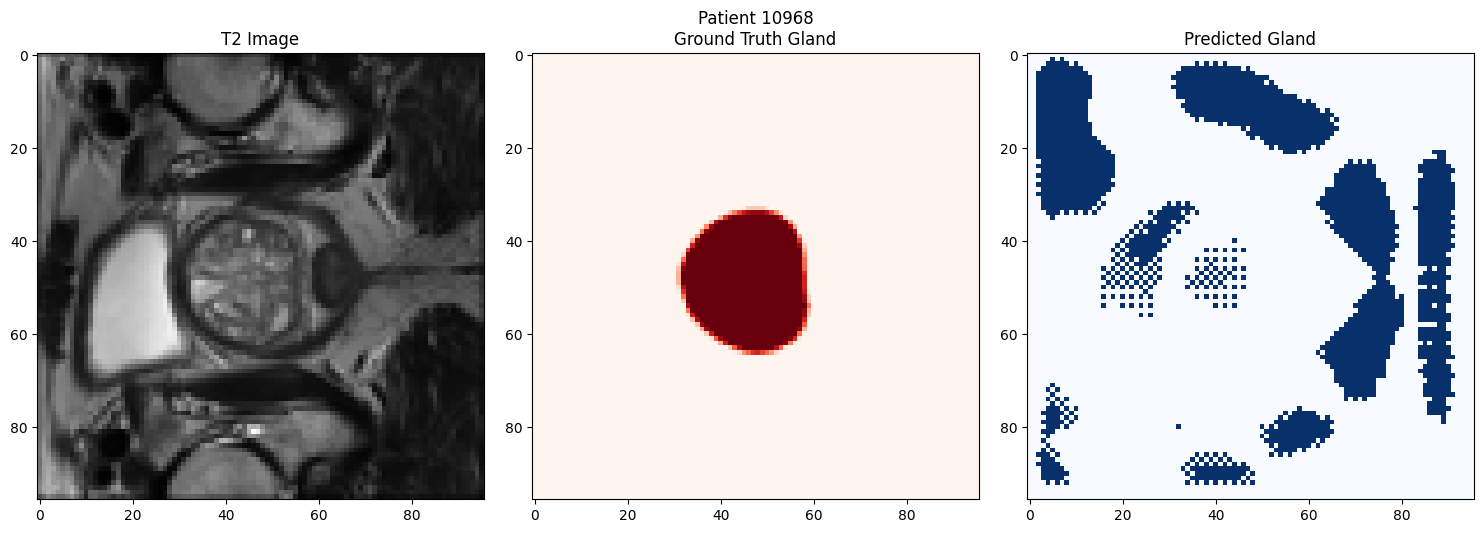

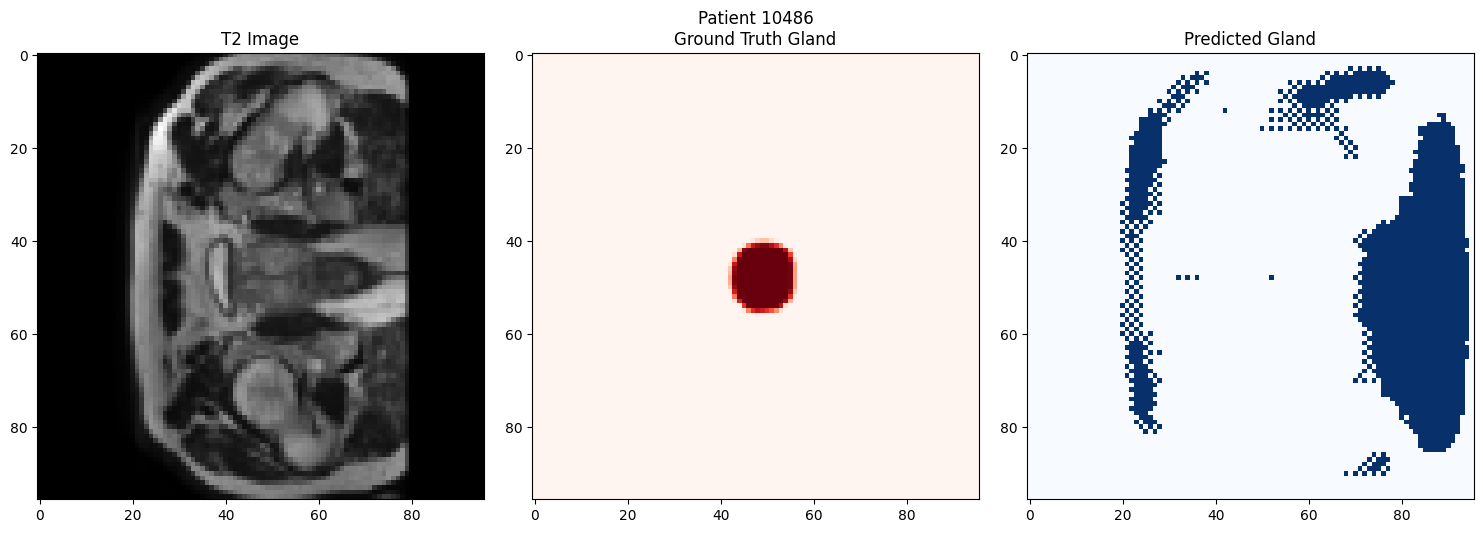

In [43]:
for pid in results_df.sort_values("dice").head(3)["patientID"]:
    visualize_prediction(pid)  # Worst 3

### Analysis of Worst Performing Predictions

The segmentation results for patients **10372**, **10968**, and **10486** reveal substantial mismatches between the predicted gland regions and the ground truth masks:

- **Patient 10372**:
  - The predicted gland includes several disconnected, scattered patches.
  - The actual gland region is entirely missed, indicating poor spatial localization.

- **Patient 10968**:
  - The prediction consists of numerous irregular regions far from the anatomical location of the prostate gland.
  - Despite a large and clearly defined ground truth gland, the model fails to identify it.

- **Patient 10486**:
  - The predicted segmentation appears as dispersed vertical blobs, not aligning with the actual gland structure.
  - The true gland region is completely overlooked.

#### Key Observations:
- All three cases show segmentation in irrelevant regions, suggesting confusion about gland positioning.
- The model often misclassifies background or unrelated tissue as gland.
- These errors highlight that **Dice scores alone may not fully reflect segmentation failures**, especially when small overlaps yield deceptively high values.

#### Conclusion:
Visual inspection is crucial to complement quantitative metrics. The current predictions lack anatomical accuracy in several low-performing cases, underscoring the need for further model tuning or data refinement.
